# Load in Appliance Data

In [ ]:
#preprocessing import

import pandas as pd
import numpy as np
import json
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report



import nltk
nltk.download('all')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
#visualizaiton import

import missingno as msno
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import files
data = files.upload()

Saving Appliances.json to Appliances.json


In [ ]:
df = pd.read_json('Appliances.json',lines=True)

In [ ]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602777 entries, 0 to 602776
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         602777 non-null  int64 
 1   vote            65262 non-null   object
 2   verified        602777 non-null  bool  
 3   reviewTime      602777 non-null  object
 4   reviewerID      602777 non-null  object
 5   asin            602777 non-null  object
 6   style           137973 non-null  object
 7   reviewerName    602762 non-null  object
 8   reviewText      602453 non-null  object
 9   summary         602649 non-null  object
 10  unixReviewTime  602777 non-null  int64 
 11  image           9258 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 51.2+ MB


In [ ]:
df.isna().sum()  #check nan values  --- 45 sec in

overall                0
vote              537515
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             464804
reviewerName          15
reviewText           324
summary              128
unixReviewTime         0
image             593519
dtype: int64

<Axes: >

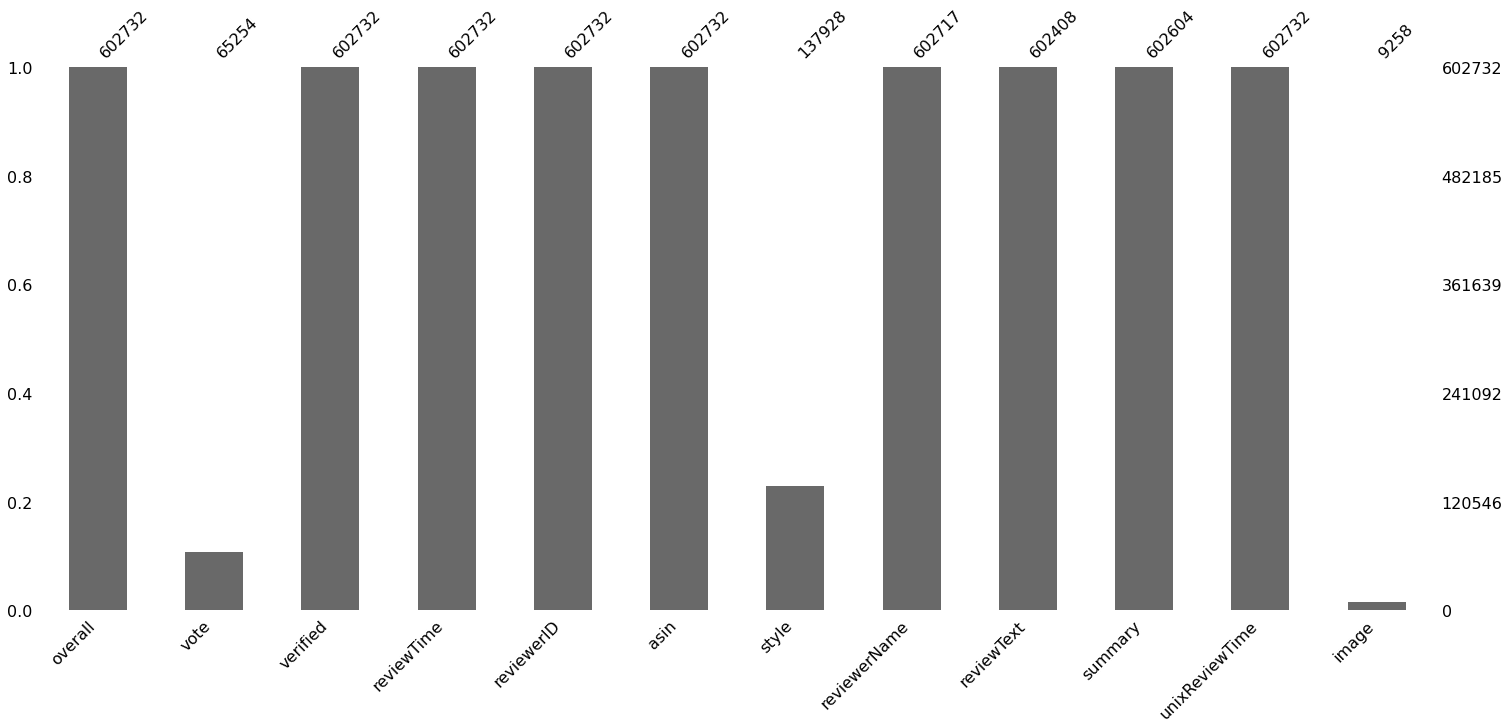

In [ ]:
msno.bar(df)  #visualize nan values

In [ ]:
#create def to visualize number of 1 star - 5 start

constraints = ['#581845','#C70039','#2E4053','#1ABC9C','#7F8C8D']     #this is to define color

def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1,cols=2,
                        subplot_titles=('Countplot','Percentages'),
                        specs=[[{"type": "xy"}, {'type':'domain'}]])

    fig.add_trace(go.Bar( y = df[column_name].value_counts().values.tolist(), 
                          x = [str(i) for i in df[column_name].value_counts().index], 
                          text = df[column_name].value_counts().values.tolist(),
                          textfont = dict(size=15),
                          name = column_name,
                          textposition = 'auto',
                          showlegend=False,
                          marker=dict(color = constraints,
                                      line=dict(color='#DBE6EC',
                                                width=1))),
                  row = 1, col = 1)
    
    fig.add_trace(go.Pie(labels= df[column_name].value_counts().keys(),
                         values= df[column_name].value_counts().values,
                         textfont = dict(size = 20),
                         textposition='auto',
                         showlegend = False,
                         name = column_name,
                         marker=dict(colors=constraints)),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': column_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    iplot(fig)


categorical_variable_summary(df,'overall')    #visualize def

# Remove Miscellaneous Reviews

In [ ]:
# Convert dictionaries in 'style' column to strings to see unique values    -> 

df['style'] = df['style'].apply(json.dumps)

In [ ]:
df['style'].unique()

array(['{"Format:": " Hardcover"}', '{"Format:": " Kindle Edition"}',
       '{"Size:": " Pack of 1"}', ..., '{"Color:": " Brushed Nickel 7"}',
       '{"Color:": " Brushed Nickel 2"}', '{"Size:": " 1D"}'],
      dtype=object)

In [ ]:
# Convert back to dictionary
df['style'] = df['style'].apply(json.loads)

In [ ]:
df.shape

(602777, 12)

In [ ]:
# Remove rows that have format of Hardcover and Kindle Edition
df = df[(df['style'] != {'Format:': ' Hardcover'}) & (df['style'] != {'Format:': ' Kindle Edition'})]

# Preprocessing

In [ ]:
reviews = df.reviewText

In [ ]:
reviews = reviews.ravel()

In [ ]:
#df.dropna(inplace = True)   #drop nan values

In [ ]:
def normalize_text(sent):
  sent = str(sent) # Convert to string
  sent = sent.lower() # lowercase
  sent = re.sub(r'\d+','',sent) # Remove digits
  sent = re.sub(r'\W',' ',sent) # remove non-alphanumeric characters
  sent = sent.strip() # Remove the whitespace
  sent = re.sub(r'\s+[a-zA-Z]\s+','',sent) # Remove single characters
  sent = re.sub(r"\d+.\d+", "", sent) # Remove floats
  sent = re.sub(r'[?|!|]',r '',sent) # Remove symbol
  sent = re.sub(r'[.|,|)|(||/]',r' ',sent) # Remove extra symbol


  stop_words = set(stopwords.words('english')) - {'not', 'no', 'never', 'don', 'dont', 'ain', 'aren', 'arent',
                                               'couldn', 'couldnt', 'didn', 'didnt', 'doesn', 'doesnt',
                                               'hadn', 'hadnt', 'hasn', 'hasnt', 'haven', 'havent',
                                               'isn', 'isnt', 'mightn', 'mightnt', 'mustn', 'mustnt',
                                               'needn', 'neednt', 'shan', 'shant', 'shouldn', 'shouldnt',
                                               'wasn', 'wasnt', 'weren', 'werent', 'won', 'wont',
                                               'wouldn', 'wouldnt'} # stop words definition, customize by removing negative words from list
  tokens = word_tokenize(sent)
  tokens = [word for word in tokens if not word in stop_words]
  lem_reviews = list(map(nltk.WordNetLemmatizer().lemmatize,tokens)) # filter base word

  return ' '.join(lem_reviews)

In [ ]:
# used list comprehension to call every line of review 
norm_reviews = [normalize_text(review) for review in reviews]
norm_reviews

['whatneeded electric range matched pigtail cord work great',
 'like fact wire end mounting tip assembled cord hasstrain relief clamp includedd recommend diy person',
 'needed another couple foot new dryer perfect fit give option shorter cord normally sold',
 'good quality atreasonable price',
 'planning hooking rv',
 'product ispretty simple onedo like prettymuch product made southwire make good stuff coleman cable nowsubsidiary southwire go big box store romex buy made southwire thhn thwn youbuy conduitlike stick brandstrust make good productshave particular complaint fit well levitonas expected well constructed sturdylike foot model iteasier install pull range needed installation simple prong crimped',
 'worked great',
 'good quality used asfeeder line amp fuze panel box enclosed trailer',
 'excellent',
 'cable work well three star maybe expectation unrealistic difficult maneuver wire around difficult get attach end arenthe loop pictured rather squared prong find picture product mad

# Vectorization with TfidfVectorizer

In [ ]:
tv=TfidfVectorizer (min_df=0.02, max_df=0.2, norm='l2', 
                    #max_df hoping to ignore common terms like 'bad' or 'good'
                    #min_df rare words aren't that informative for reviews
                  use_idf=True, smooth_idf=True)
tv_matrix=tv.fit_transform(norm_reviews)
tv_matrix=tv_matrix.toarray()
vocab=tv.get_feature_names_out()
pd.DataFrame (np.round(tv_matrix,2), columns=vocab)

,also,amazon,another,arrived,back,better,bought,brand,buy,came,...,used,using,washer,water,way,well,worked,working,would,year
0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.48,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602727,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602728,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602729,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602730,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Binary Classification with Logistic Regression

In [ ]:
# X is the reviews, being the independent variable, pulled from TfidfVectorizer cell
X = tv.fit_transform(norm_reviews).toarray()

In [ ]:
# Check columns to find ratings variable
df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

In [ ]:
# Change ratings to binary
new_df = pd.DataFrame({'reviewText': df['reviewText'], 'label': df['overall'].apply(lambda x: 1 if x >= 4 else 0)})

In [ ]:
# y is the classified rating, will combine ratings to have binary values
y = new_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Logistic Regression

lr = LogisticRegression(max_iter=1500) # max_iter to deal with large number of reviews

In [ ]:
lr.fit(X_train,y_train) # fit model

LogisticRegression(max_iter=1500)

In [ ]:
y_pred = lr.predict(X_test)

# Evaluation of Logistic Model

In [ ]:
print(classification_report(y_test,y_pred,target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.65      0.32      0.43     27968
    positive       0.86      0.96      0.91    122715

    accuracy                           0.84    150683
   macro avg       0.75      0.64      0.67    150683
weighted avg       0.82      0.84      0.82    150683



In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[  9030,  18938],
       [  4914, 117801]])

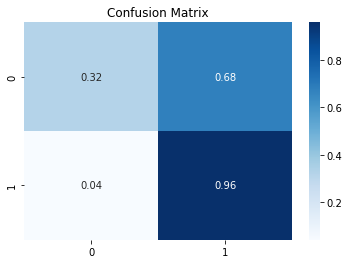

In [ ]:
# Color confusion matrix and percentage

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Percentages
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## VADER for Sentiment Analysis

In [ ]:
# Bring in the predicted labels
pred_labels = lr.predict(X)

In [ ]:
reviews_df = pd.DataFrame({'reviews': df.reviewText, 'predicted_labels': pred_labels})
reviews_df

,reviews,predicted_labels
35,Just what I needed for my electric range. Matc...,1
36,I like the fact that the wire ends have mounti...,1
37,"Needed another couple of feet with new dryer, ...",1
38,Good quality at a reasonable price,1
39,Planning on hooking this to my RV,1
...,...,...
602772,perfect replacement for our broken one.,1
602773,"Quick delivery, did not fit my stove.",1
602774,Perfect match for my oven!,1
602775,Doesn't work with Bosch SHX33A06UC/14 dishwash...,1


In [ ]:
# define pos and neg values(1 and 0) 
all_positive = reviews_df[reviews_df['predicted_labels'] == 1]['reviews']
all_negative = reviews_df[reviews_df['predicted_labels'] == 0]['reviews']

In [ ]:
#apply 1 and 0 to labels
my_labels = [1]*len(all_positive)
negative_labels = [0]*len(all_negative)
my_labels.extend(negative_labels)

all_positive = all_positive.append(all_negative)

mod_df = pd.DataFrame({'reviews' : all_positive, 
                   'my_labels' : my_labels})

mod_df

<ipython-input-135-0b3ea9d3bd8a>:5: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,reviews,my_labels
35,Just what I needed for my electric range. Matc...,1
36,I like the fact that the wire ends have mounti...,1
37,"Needed another couple of feet with new dryer, ...",1
38,Good quality at a reasonable price,1
39,Planning on hooking this to my RV,1
...,...,...
602747,"I actually bought this product, along with a d...",0
602748,"It's not a half inch hose more like 3/8,and do...",0
602749,Hose was unusable; the connector on one side c...,0
602751,"The original one lasted about 3 years, then I ...",0


In [ ]:
# Convert norm_reviews to DataFrame
norm_reviews = pd.DataFrame(norm_reviews, columns=['reviewText'])

In [ ]:
mod_df['neg'] = norm_reviews['reviewText'].apply(lambda x: sia.polarity_scores(x)['neg'])
mod_df['neu'] = norm_reviews['reviewText'].apply(lambda x: sia.polarity_scores(x)['neu'])
mod_df['pos'] = norm_reviews['reviewText'].apply(lambda x: sia.polarity_scores(x)['pos'])
mod_df['compound'] = norm_reviews['reviewText'].apply(lambda x: sia.polarity_scores(x)['compound'])

mod_df.head()

,reviews,my_labels,neg,neu,pos,compound
35,Just what I needed for my electric range. Matc...,1,0.0,1.000,0.000,0.0000
36,I like the fact that the wire ends have mounti...,1,0.0,1.000,0.000,0.0000
37,"Needed another couple of feet with new dryer, ...",1,0.0,0.299,0.701,0.5719
38,Good quality at a reasonable price,1,0.0,1.000,0.000,0.0000
39,Planning on hooking this to my RV,1,0.0,0.904,0.096,0.1027


In [ ]:
mod_df['comp_score']=mod_df['compound'].apply(lambda c: 'pos' if c > 0.05 else 'neg' if c < 0 else 'nue')

In [ ]:
mod_df['sen_score'] = mod_df['my_labels'].apply(lambda x: 'pos' if x == 1 else 'neg')

In [ ]:
mod_df

,reviews,my_labels,neg,neu,pos,compound,comp_score,sen_score
35,Just what I needed for my electric range. Matc...,1,0.0,1.000,0.000,0.0000,nue,pos
36,I like the fact that the wire ends have mounti...,1,0.0,1.000,0.000,0.0000,nue,pos
37,"Needed another couple of feet with new dryer, ...",1,0.0,0.299,0.701,0.5719,pos,pos
38,Good quality at a reasonable price,1,0.0,1.000,0.000,0.0000,nue,pos
39,Planning on hooking this to my RV,1,0.0,0.904,0.096,0.1027,pos,pos
...,...,...,...,...,...,...,...,...
602747,"I actually bought this product, along with a d...",0,NaN,NaN,NaN,NaN,nue,neg
602748,"It's not a half inch hose more like 3/8,and do...",0,NaN,NaN,NaN,NaN,nue,neg
602749,Hose was unusable; the connector on one side c...,0,NaN,NaN,NaN,NaN,nue,neg
602751,"The original one lasted about 3 years, then I ...",0,NaN,NaN,NaN,NaN,nue,neg


In [ ]:
temp_1 = mod_df[mod_df['my_labels'] == 1]
temp_1.tail(5)

,reviews,my_labels,neg,neu,pos,compound,comp_score,sen_score
602772,perfect replacement for our broken one.,1,NaN,NaN,NaN,NaN,nue,pos
602773,"Quick delivery, did not fit my stove.",1,NaN,NaN,NaN,NaN,nue,pos
602774,Perfect match for my oven!,1,NaN,NaN,NaN,NaN,nue,pos
602775,Doesn't work with Bosch SHX33A06UC/14 dishwash...,1,NaN,NaN,NaN,NaN,nue,pos
602776,The switch works with my dishwasher after I mo...,1,NaN,NaN,NaN,NaN,nue,pos


In [ ]:
temp_0 = mod_df[mod_df['my_labels'] == 0]
temp_0.tail(5)

,reviews,my_labels,neg,neu,pos,compound,comp_score,sen_score
602747,"I actually bought this product, along with a d...",0,NaN,NaN,NaN,NaN,nue,neg
602748,"It's not a half inch hose more like 3/8,and do...",0,NaN,NaN,NaN,NaN,nue,neg
602749,Hose was unusable; the connector on one side c...,0,NaN,NaN,NaN,NaN,nue,neg
602751,"The original one lasted about 3 years, then I ...",0,NaN,NaN,NaN,NaN,nue,neg
602761,"Gasket was too short, so it did not stop the l...",0,NaN,NaN,NaN,NaN,nue,neg


In [ ]:
#sia.polarity_scores not running through whole dataframe - not sure why or how to fix
#if use .head, we have values, but .tails shows us NaN values, which messes up our results
#we have values for .tail, but it changes to NaN if we run sia.polarity_scores

In [ ]:
mod_df.isna().sum()  #check for "damages" caused by sia.polarity_scores -- around 500 NaN values created

reviews       324
my_labels       0
neg            45
neu            45
pos            45
compound       45
comp_score      0
sen_score       0
dtype: int64

##Visualization

In [ ]:
mod_df.groupby('my_labels')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
my_labels,,,,,,,,
0,55348.0,0.427046,0.432298,-0.9967,0.0516,0.5719,0.7717,0.9996
1,547339.0,0.437130,0.412206,-0.9964,0.1027,0.5719,0.7650,0.9996


<Axes: title={'center': 'compound'}, xlabel='my_labels'>

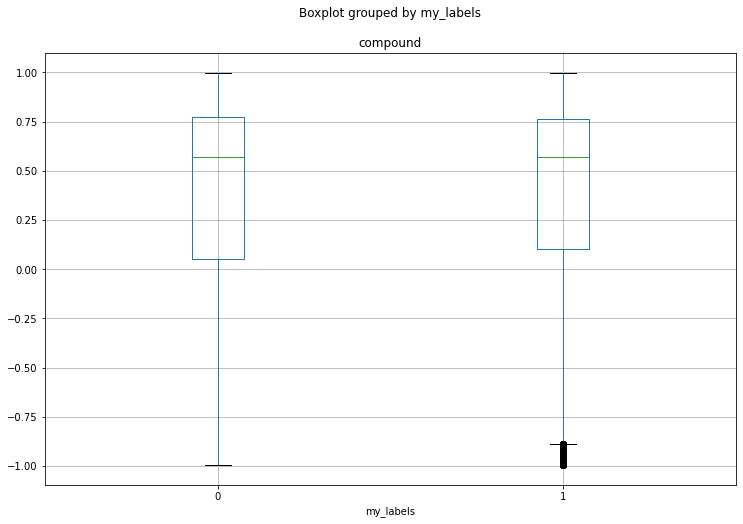

In [ ]:
mod_df.boxplot(by='my_labels', column='compound', figsize=(12,8))

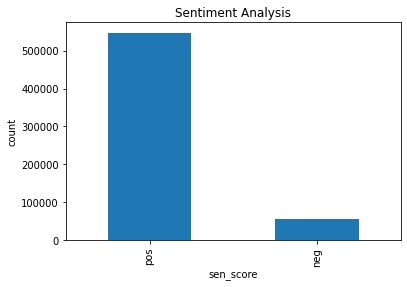

In [ ]:
plt.title('Sentiment Analysis')
plt.xlabel('sen_score')
plt.ylabel('count')
mod_df['sen_score'].value_counts().plot(kind = 'bar')
plt.show()

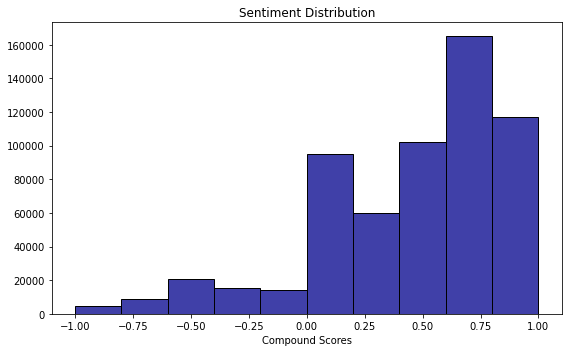

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(mod_df, x='compound', color="darkblue", bins=10, binrange=(-1, 1))
plt.title("Sentiment Distribution")
plt.xlabel("Compound Scores")
plt.ylabel("")
plt.tight_layout()

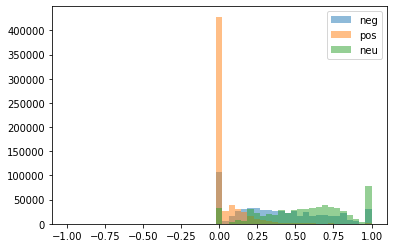

In [ ]:
x = mod_df['pos']
y = mod_df['neg']
z = mod_df['neu']

bins = np.linspace(-1,1)


plt.hist(x, bins, alpha=0.5, label='neg')
plt.hist(y, bins, alpha=0.5, label='pos')
plt.hist(z, bins, alpha=0.5, label='neu')
plt.legend(loc='upper right')
plt.show()

Interpretation: We can see in the boxplot below that the positive sentiment was predicted accurately, but could be better, as there are some values below the .5 area, but for the negative sentiment, we can see the predicted was at the positive area, which means that it was not predicted accurately.